In [70]:
import pandas as pd

df = pd.read_csv("../data/processed/01_covid_hiv_data.csv")

In [ ]:
df = df[df["facility"] != -1]
df = df[df["facility"].notnull()]

START_DATE = (6, 2018)
END_DATE = (12, 2022)

HIGH_VISITS_START_DATE = (1, 2021)
HIGH_VISITS_END_DATE = (8, 2022)

start_date_point = df[(df["month"] == START_DATE[0]) & (df["year"] == START_DATE[1])]["visit_date"].tolist()[0]
end_date_point = df[(df["month"] == END_DATE[0]) & (df["year"] == END_DATE[1])]["visit_date"].tolist()[-1]

df = df[(df["visit_date"] >= start_date_point) & (df["visit_date"] <= end_date_point)].reset_index(drop=True)
print(df.shape)

all_months = []
for v in df[["month", "year"]].values:
    all_months += [tuple(v)]
all_months = set(all_months)

MONTHS_DICT = {}
i = 0
for y in sorted(set(df["year"].tolist())):
    for m in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        if (m, y) not in all_months:
            continue
        MONTHS_DICT[(m, y)] = i
        i += 1

MONTHS_DICT_INV = {v: k for k, v in MONTHS_DICT.items()}


def cummulative_months(df):
    months = []
    for m, y in df[["month", "year"]].values:
        months += [MONTHS_DICT[(m, y)]]
    return months

df["month_cum"] = cummulative_months(df)

(7047446, 25)


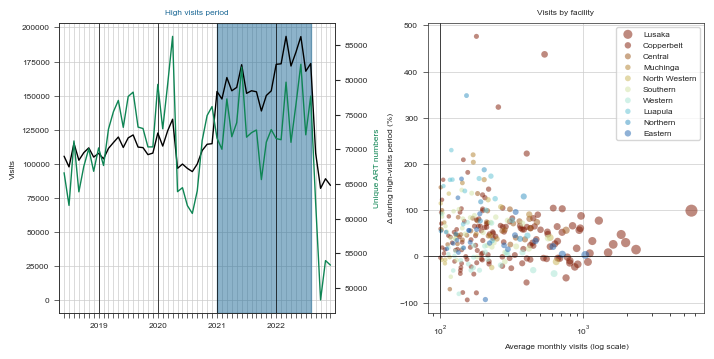

In [ ]:
from adjustText import adjust_text
from stylia.colors.colors import NamedColors

fig, axs = stylia.create_figure(1, 2, width = stylia.TWO_COLUMNS_WIDTH, height = stylia.TWO_COLUMNS_WIDTH*0.5)

months = sorted(set(df["month_cum"].tolist()))
x = []
y1 = []
y2 = []
for m in months:
    dfm = df[df["month_cum"] == m]
    x += [m]
    y1 += [dfm.shape[0]]
    y2 += [len(set(dfm["id"]))]

colors = NamedColors()

ax = axs.next()
ax.plot(months, y1, color=colors.black, lw=1)
ax2 = ax.twinx()
ax2.plot(months, y2, color=colors.green, lw=1)
ax2.grid(False)

map_months_axis(ax, x)
ax.set_xlim(-1, max(x)+1)

xstart = MONTHS_DICT[HIGH_VISITS_START_DATE]
xend = MONTHS_DICT[HIGH_VISITS_END_DATE]

ax.fill_between([xstart, xend], [-0.05*max(y1), -0.05*max(y1)], [max(y1)*1.05, max(y1)*1.05], alpha=0.5, color=colors.blue)

ax.set_ylim(-0.05*max(y1), 1.05*max(y1))

ax.set_ylabel("Visits")
ax2.set_ylabel("Unique ART numbers", color=colors.green)
ax.set_xlabel("")

ax.set_title("High visits period", color=colors.blue)

# Facilities plot

import numpy as np

import csv
import stylia

from stylia.colors.colors import ContinuousColorMap

unique_months = sorted(set(df["month_cum"]))

d_ = df[df["facility"] != -1]
all_facilities = sorted(set(d_["facility"]))

R = []
for facility in all_facilities:
    df_ = df[df["facility"] == facility]
    province = list(df_.value_counts("province").index)[0]
    for m in unique_months:
        n = df_[df_["month_cum"] == m].shape[0]
        R += [[m, facility, province, n]]

dr = pd.DataFrame(R, columns=["month_cum", "facility", "province", "n_visits"])


top_facilities = []
for facility in sorted(set(dr["facility"])):
    avg_visits = np.mean(dr[dr["facility"] == facility]["n_visits"])
    if avg_visits < 100:
        continue
    top_facilities += [facility]


facility_dict = {}
with open("../data/codebook/facility.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)
    for r in reader:
        facility_dict[int(r[0])] = r[1]

province_dict = {}
with open("../data/codebook/province.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)
    for r in reader:
        province_dict[int(r[0])] = r[1]

cmap = ContinuousColorMap()
cmap.fit([1, len(province_dict)])
col = cmap.transform([i for i in range(len(province_dict.keys()))])
province_colors = {}
for i, k in enumerate(sorted(province_dict.keys())):
    province_colors[k] = col[i]

dr = pd.DataFrame(R, columns=["month_cum", "facility", "province", "n_visits"])

province_labels = []
labels = []
x = []
y = []
colors_ = []
for facility in top_facilities:
    df_ = dr[dr["facility"] == facility]
    do = df_[(df_["month_cum"] < MONTHS_DICT[HIGH_VISITS_START_DATE]) | (df_["month_cum"] > MONTHS_DICT[HIGH_VISITS_END_DATE])]
    di = df_[(df_["month_cum"] >= MONTHS_DICT[HIGH_VISITS_START_DATE]) & (df_["month_cum"] <= MONTHS_DICT[HIGH_VISITS_END_DATE])]
    avg_i = di["n_visits"].mean()
    avg_o = do["n_visits"].mean()
    avg_t = df_["n_visits"].mean()
    std_i = di["n_visits"].std()
    std_o = do["n_visits"].std()
    labels += [facility_dict[facility]]
    prov = df_["province"].tolist()[0]
    colors_ += [province_colors[prov]]
    province_labels += [province_dict[prov]]
    x += [avg_t]
    y += [(avg_i - avg_o) / avg_o * 100 if avg_o > 0 else np.nan]

ax = axs.next()

for k, v in province_dict.items():
    idxs = [i for i, l in enumerate(province_labels) if l == v]
    c_ = [colors_[i] for i in idxs]
    x_ = [x[i] for i in idxs]
    y_ = [y[i] for i in idxs]
    ax.scatter(x_, y_, color=c_[0], s=np.sqrt(x_), alpha=0.5, lw=0, edgecolor="none", label = v)
ax.set_xscale('log')
ax.legend(loc="upper right")

ax.set_xlabel('Average monthly visits (log scale)')
ax.set_ylabel('Δ during high-visits period (%)')
ax.axhline(0, color="black")
ax.axvline(100, color="black")

ax.set_title('Visits by facility')
#ax.set_ylim(-100, 2000)

plt.tight_layout()

stylia.save_figure("../assets/high_visits_period.png")
stylia.save_figure("../assets/high_visits_period.pdf")

# Identifier specific

In [306]:
import collections
from tqdm import tqdm

id_visits = collections.defaultdict(list)

for v in tqdm(df[["id", "visit_date", "viremic"]].values):
    id_visits[v[0]] += [(v[1], v[2])]

100%|██████████| 7047446/7047446 [00:08<00:00, 820674.47it/s] 


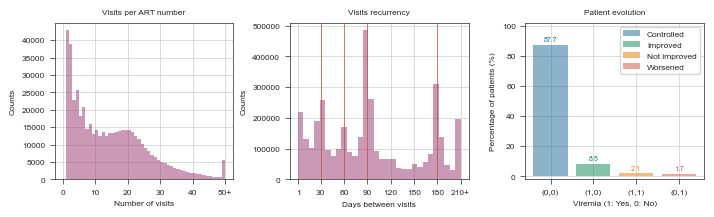

In [417]:
from stylia.colors.colors import NamedColors

colors = NamedColors()

fig, axs = stylia.create_figure(1, 3, width=stylia.TWO_COLUMNS_WIDTH, height=stylia.TWO_COLUMNS_WIDTH*0.3)

ax = axs.next()

ax.hist(np.clip([len(v) for _,v in id_visits.items()], 0, 50), bins=50, lw=0, color=colors.purple, alpha=0.5)
ax.set_xlabel("Number of visits")
ax.set_ylabel("Counts")
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(["0", "10", "20", "30", "40", "50+"])
ax.set_title("Visits per ART number")

ax = axs.next()

distance = []
for k,v in id_visits.items():
    if len(v) == 1:
        continue
    for i in range(len(v) - 1):
        distance += [v[i+1][0] - v[i][0]]

ax.hist(np.clip([x for x in distance if x > 0], 1, 210), bins=30, edgecolor="none", color=colors.purple, alpha=0.5)
ax.set_xticks([1, 30, 60, 90, 120, 150, 180, 210])
ax.set_xticklabels(["1", "30", "60", "90", "120", "150", "180", "210+"])
ax.set_xlabel("Days between visits")
ax.set_ylabel("Counts")
ax.set_title("Visits recurrency")
ax.axvline(30, color=colors.red)
ax.axvline(60, color=colors.red)
ax.axvline(90, color=colors.red)
ax.axvline(180, color=colors.red)

ax = axs.next()

id_visits_viremia = {}
for k,v in id_visits.items():
    r = [x for x in v if x[1] != -1]
    if len(r) > 0:
        id_visits_viremia[k] = r

controlled = 0
improved = 0
worsened = 0
not_improved = 0
n = 0
for k,v in id_visits_viremia.items():
    v = [x[1] for x in v]
    if len(v) == 1:
        continue
    if v[0] == 0 and v[-1] == 0:
        controlled += 1
    elif v[0] == 0 and v[-1] == 1:
        worsened += 1
    elif v[0] == 1 and v[-1] == 0:
        improved += 1
    elif v[0] == 1 and v[-1] == 1:
        not_improved += 1
    else:
        raise Exception("Impossible combination")
    n += 1

cols = [colors.blue, colors.green, colors.orange, colors.red]
labels = ["Controlled", "Improved", "Not improved", "Worsened"]

for i, y in enumerate([controlled/n*100, improved/n*100, not_improved/n*100, worsened/n*100]):
    ax.bar([i], [y], facecolor=cols[i], edgecolor="none", label=labels[i], alpha=0.5)

ax.set_xticks([0, 1, 2, 3])

for i, x in enumerate([controlled, improved, not_improved, worsened]):
    ax.text(i, x/n*100 + 2, "{0:.1f}".format(x/n*100), color=cols[i], ha="center")

ax.set_xticklabels(["(0,0)", "(1,0)", "(1,1)", "(0,1)"])
ax.set_ylabel("Percentage of patients (%)")
ax.set_xlabel("Viremia (1: Yes, 0: No)")
ax.set_ylim(-2, 102)
ax.legend()
ax.set_title("Patient evolution")

plt.tight_layout()

stylia.save_figure("../assets/visits_per_art.png")
stylia.save_figure("../assets/visits_per_art.pdf")

In [402]:
days_0 = 0
days_7 = 0
days_30 = 0
days_60 = 0
days_90 = 0
days_180 = 0
days_180plus = 0

for d in distance:
    if d == 0:
        days_0 += 1
        continue
    if d <= 7:
        days_7 += 1
        continue
    if d <= 30:
        days_30 += 1
        continue
    if d <= 60:
        days_60 += 1
        continue
    if d <= 90:
        days_90 += 1
        continue
    if d <= 180:
        days_180 += 1
        continue
    else:
        days_180plus += 1
        continue

<BarContainer object of 7 artists>

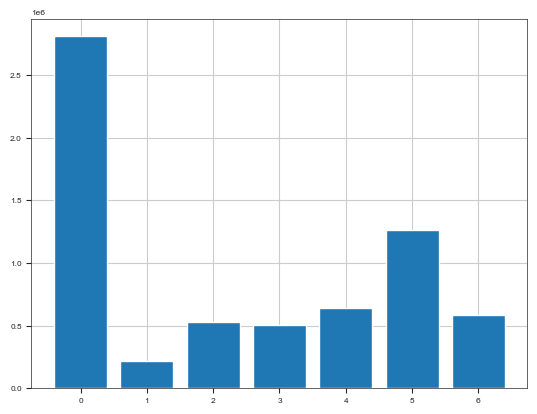

In [404]:
plt.bar([0, 1, 2, 3, 4, 5, 6], [days_0, days_7, days_30, days_60, days_90, days_180, days_180plus])

(array([143711.,  50450.,  51680.,  35792.,  89449.,  34494.,  45199.,
         35472.,  55724., 203089.,  92752.,  79281.,  33210.,  45226.,
         29976.,  28498.,  37813.,  26289.,  69735.,  61692.,  91438.,
         35852.,  30772.,  40556.,  24592.,  43601.,  28581.,  98069.,
         69567., 180508., 356423.,  73437.,  83445.,  31204.,  44389.,
         24630.,  23360.,  34382.,  19219.,  45874.,  25168.,  28696.,
         15339.,  13937.,  18024.,  10585.,  18429.,  10421.,  19858.,
         16279.,  20245.,  23138.,  12576.,  23682.,  14229.,  36115.,
         21126.,  26310.,  73874., 103002., 208567.,  51920.,  47569.,
         20060.,  15939.,  19864.,   9628.,  15212.,   7955., 184998.]),
 array([  1.        ,   3.98571429,   6.97142857,   9.95714286,
         12.94285714,  15.92857143,  18.91428571,  21.9       ,
         24.88571429,  27.87142857,  30.85714286,  33.84285714,
         36.82857143,  39.81428571,  42.8       ,  45.78571429,
         48.77142857,  51.757142

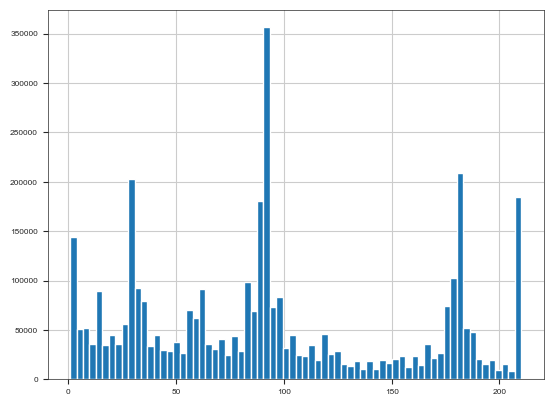

(0.0, 100.0)

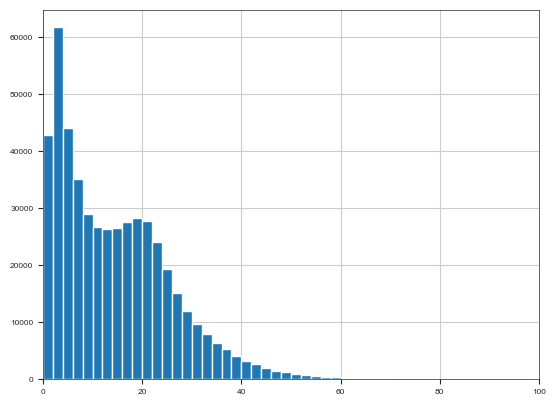

In [356]:
plt.hist(np.clip(v, 0, 100), bins=50)
plt.xlim(0, 100)

In [330]:
d = []
for k, v in tqdm(id_visits.items()):
    if len(v) == 1:
        continue
    for i in range(len(v) - 1):
        d += [v[i+1][0] - v[i][0]]

100%|██████████| 495392/495392 [00:04<00:00, 116729.98it/s]


In [340]:
id_visits_viremia = {}
for k,v in id_visits.items():
    r = [x for x in v if x[1] != -1]
    if len(r) > 0:
        id_visits_viremia[k] = r

In [353]:
controlled = 0
improved = 0
worsened = 0
not_improved = 0
n = 0
for k,v in id_visits_viremia.items():
    v = [x[1] for x in v]
    if len(v) == 1:
        continue
    if v[0] == 0 and v[-1] == 0:
        controlled += 1
    elif v[0] == 0 and v[-1] == 1:
        worsened += 1
    elif v[0] == 1 and v[-1] == 0:
        improved += 1
    elif v[0] == 1 and v[-1] == 1:
        not_improved += 1
    else:
        raise Exception("Impossible combination")
    n += 1


<BarContainer object of 4 artists>

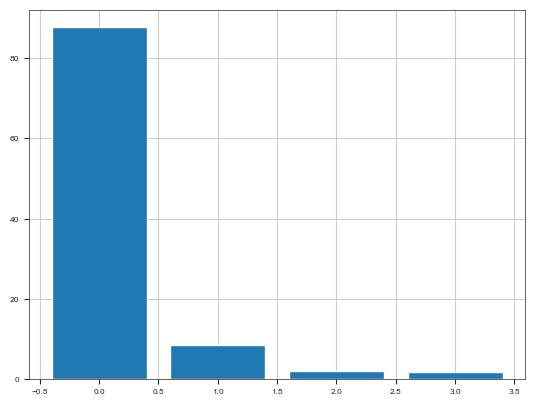

In [354]:
plt.bar([0, 1, 2, 3], [controlled/n*100, improved/n*100, not_improved/n*100, worsened/n*100])

(array([257077., 172870., 315113., 215973., 122124., 166375., 179129.,
        106400., 358007., 525236., 102327., 108800.,  73383.,  52218.,
         51135.,  62235.,  82875., 209187., 316893.,  53272.,  39855.,
         22720.,  12478.,   9947.,   7430.,   6876.,   6641.,   8032.,
          4129.,   3738.,   4240.,   3048.,   3715.,   4323.,   4790.,
          7060.,   7218.,   3630.,   2510.,   2699.,   1875.,   1998.,
          1853.,   1632.,   1935.,   2111.,   1508.,   1197.,   1300.,
         31059.]),
 array([  1.  ,  10.98,  20.96,  30.94,  40.92,  50.9 ,  60.88,  70.86,
         80.84,  90.82, 100.8 , 110.78, 120.76, 130.74, 140.72, 150.7 ,
        160.68, 170.66, 180.64, 190.62, 200.6 , 210.58, 220.56, 230.54,
        240.52, 250.5 , 260.48, 270.46, 280.44, 290.42, 300.4 , 310.38,
        320.36, 330.34, 340.32, 350.3 , 360.28, 370.26, 380.24, 390.22,
        400.2 , 410.18, 420.16, 430.14, 440.12, 450.1 , 460.08, 470.06,
        480.04, 490.02, 500.  ]),
 <BarContainer obj

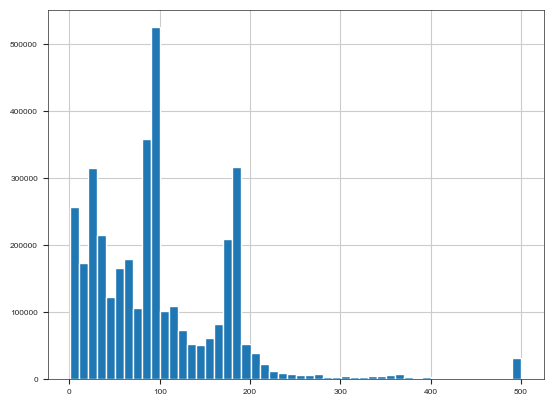

In [ ]:
id_visits

# Age by sex

In [ ]:
df.head()



,index,id,visit_date,day,month,year,age,age_cat,sex_female,marital_status,...,district,province,covid_wave,vaccine,rna,cd4,viremic,died,retention,month_cum
0,623503,2039510,516,1,6,2018,26,3,0,1,...,4,2,0,0,-1,-1,-1,0,0,0
1,623504,3603183,516,1,6,2018,33,4,1,1,...,2,2,0,0,-1,-1,-1,0,2,0
2,623505,2130966,516,1,6,2018,51,6,1,3,...,1,1,0,0,-1,-1,-1,0,0,0
3,623506,6863588,516,1,6,2018,37,4,0,2,...,1,1,0,0,-1,-1,-1,0,0,0
4,623507,6147310,516,1,6,2018,28,3,1,2,...,35,9,0,0,-1,-1,-1,0,0,0


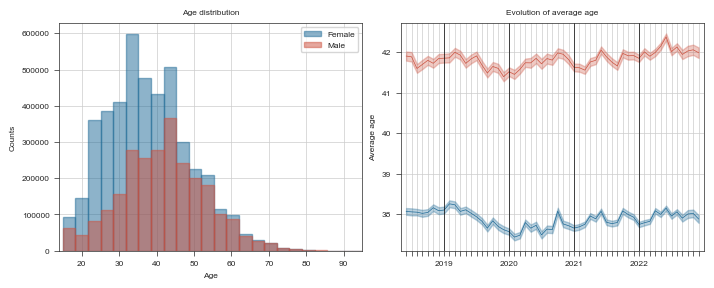

In [155]:
from stylia.colors.colors import NamedColors

colors = NamedColors()

def map_months_axis(ax, x):
    month_dict_inv = MONTHS_DICT_INV
    xticklabels = []
    for x_ in x:
        m, y = month_dict_inv[x_]
        if m == 1:
            xticklabels += [y]
            ax.axvline(x_, color="black")
        else:
            xticklabels += [""]
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("")

months = sorted(set(df["month_cum"].tolist()))

x = []
ym = []
yf = []
for m in months:
    dm = df[df["month_cum"] == m]
    dm = dm[dm["age"].notnull()]
    am = list(dm[dm["sex_female"] == 0]["age"])
    af = list(dm[dm["sex_female"] == 1]["age"])
    # 95% confidence interval: mean ± 1.96 * std / sqrt(n)
    if len(af) > 1:
        mean_af = np.mean(af)
        std_af = np.std(af, ddof=1)
        n_af = len(af)
        ci_af = 1.96 * std_af / np.sqrt(n_af)
        yf += [(mean_af, mean_af - ci_af, mean_af + ci_af)]
    else:
        yf += [(np.nan, np.nan, np.nan)]
    if len(am) > 1:
        mean_am = np.mean(am)
        std_am = np.std(am, ddof=1)
        n_am = len(am)
        ci_am = 1.96 * std_am / np.sqrt(n_am)
        ym += [(mean_am, mean_am - ci_am, mean_am + ci_am)]
    else:
        ym += [(np.nan, np.nan, np.nan)]
    x += [m]

fig, axs = stylia.create_figure(1, 2, width = stylia.TWO_COLUMNS_WIDTH, height = stylia.TWO_COLUMNS_WIDTH*0.4)

ax = axs.next()

ax.hist(df[(df["sex_female"] == 1) & (df["age"] < 100)]["age"], alpha=0.5, bins=25, label="Female", edgecolor=colors.blue, facecolor=colors.blue)
ax.hist(df[(df["sex_female"] == 0) & (df["age"] < 100)]["age"], alpha=0.5, bins=25, label="Male", edgecolor=colors.red, facecolor=colors.red)
ax.set_title("Age distribution")
ax.set_ylabel("Counts")
ax.set_xlabel("Age")
ax.legend(loc="upper right")
ax.set_xlim(14, 95)

ax = axs.next()
ax.plot(x, [y[0] for y in ym], label = "Male", color=colors.red)
ax.fill_between(x, [y[1] for y in ym], [y[2] for y in ym], color=colors.red, alpha=0.3)
ax.plot(x, [y[0] for y in yf], label = "Female", color = colors.blue)
ax.fill_between(x, [y[1] for y in yf], [y[2] for y in yf], color=colors.blue, alpha=0.3)
ax.set_xlabel("Month")
ax.set_ylabel("Average age")
ax.set_title("Evolution of average age")
map_months_axis(ax, x)
ax.set_xlim(-1, max(months) + 1)

plt.tight_layout()

stylia.save_figure("../assets/age_distribution_and_trends.png")
stylia.save_figure("../assets/age_distribution_and_trends.pdf")

# Treament

In [ ]:
import csv


art_regimen = {}
with open("../data/codebook/art_regimen.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)
    for r in reader:
        art_regimen[int(r[0])] = r[1]


df_ = df[df["art_regimen"] != -1]



In [282]:
arts = ["DTG", "EFV", "Other"]

R = []
months = sorted(set(df["month_cum"].tolist()))
for month in months:
    dm = df_[df_["month_cum"] == month]
    dtg = []
    efv = []
    other = []
    for art in dm["art_regimen"].tolist():
        art = art_regimen[art]
        if "DTG" in art:
            dtg += [1]
        else:
            dtg += [0]
        if "EFV" in art:
            efv += [1]
        else:
            efv += [0]
        if "DTG" not in art and "EFV" not in art:
            other += [1]
        else:
            other += [0]
    
    R += [[month, np.sum(dtg), np.sum(efv), np.sum(other)]]

dr = pd.DataFrame(R, columns=["month_cum", "dtg", "efv", "other"])
        

In [289]:
arts = ["DTG", "EFV", "Other"]

R = []
months = sorted(set(df["month_cum"].tolist()))
for month in months:
    dm = df_[df_["month_cum"] == month]
    dm = dm[dm["viremic"] != -1]
    dtg = []
    efv = []
    other = []
    for art in dm["art_regimen"].tolist():
        art = art_regimen[art]
        if "DTG" in art:
            dtg += [1]
        else:
            dtg += [0]
        if "EFV" in art:
            efv += [1]
        else:
            efv += [0]
        if "DTG" not in art and "EFV" not in art:
            other += [1]
        else:
            other += [0]
    viremic = np.array(dm["viremic"].tolist())
    d = pd.DataFrame({"dtg": dtg, "efv": efv, "other": other, "viremic": viremic})
    dtg_p = d[(d["dtg"] == 1) & (d["viremic"] == 1)].shape[0]/d[d["dtg"] == 1].shape[0]*100
    efv_p = d[(d["efv"] == 1) & (d["viremic"] == 1)].shape[0]/d[d["efv"] == 1].shape[0]*100
    other_p = d[(d["other"] == 1) & (d["viremic"] == 1)].shape[0]/d[d["other"] == 1].shape[0]*100
    R += [[month, dtg_p, efv_p, other_p]]

dv = pd.DataFrame(R, columns=["month_cum", "dtg", "efv", "other"])

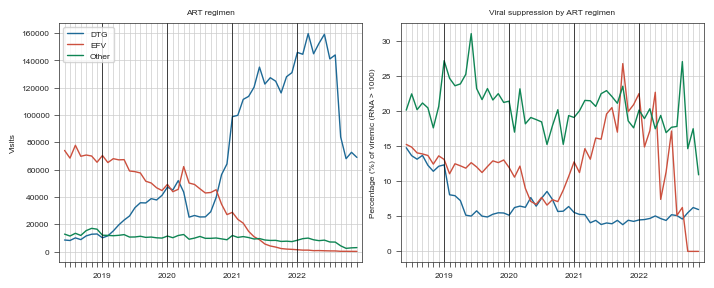

In [294]:
fig, axs = stylia.create_figure(1, 2, width = stylia.TWO_COLUMNS_WIDTH, height = stylia.TWO_COLUMNS_WIDTH*0.4)

ax = axs.next()
ax.plot(dr["month_cum"], dr["dtg"], label="DTG", color=colors.blue, lw=1)
ax.plot(dr["month_cum"], dr["efv"], label="EFV", color=colors.red, lw=1)
ax.plot(dr["month_cum"], dr["other"], label="Other", color=colors.green, lw=1)
ax.legend(loc="upper left")
ax.set_ylabel("Visits")
map_months_axis(ax, dr["month_cum"])
ax.set_xlim(-1, max(dr["month_cum"])+1)
ax.set_title("ART regimen")

ax = axs.next()
ax.plot(dv["month_cum"], dv["dtg"], label="DTG", color=colors.blue, lw=1)
ax.plot(dv["month_cum"], dv["efv"], label="EFV", color=colors.red, lw=1)
ax.plot(dv["month_cum"], dv["other"], label="Other", color=colors.green, lw=1)
#ax.legend(loc="upper left")
ax.set_ylabel("Percentage (%) of viremic (RNA > 1000)")
map_months_axis(ax, dv["month_cum"])
ax.set_xlim(-1, max(dv["month_cum"])+1)
ax.set_title("Viral suppression by ART regimen")

plt.tight_layout()

stylia.save_figure("../assets/art_regimen_trends.png")
stylia.save_figure("../assets/art_regimen_trends.pdf")